In [169]:
import numpy as np
import scipy as sci
import math
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
import matplotlib.pyplot as plt 
import pandas as pd

**Actividad 1**

En esta actividad la idea principal es medir el espectro característico de rayos X del cobre (Cu). Para esto, se utilizó el montaje  que se ve en la figura. Tomamos datos como se indicó en la guía. Acá primero vamos a definir las funciones de ajuste que usaremos en el análisis.


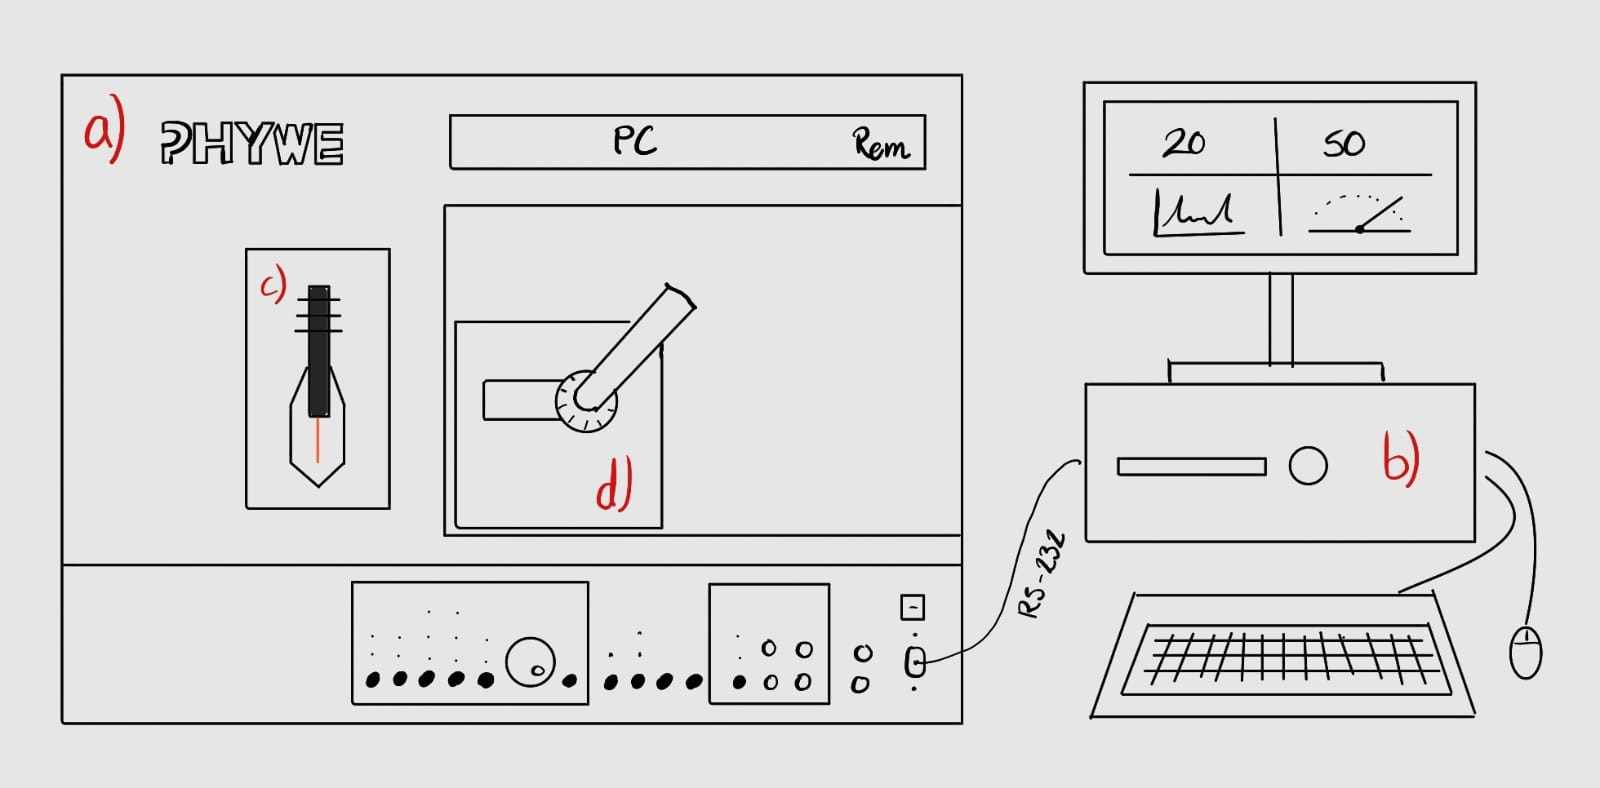

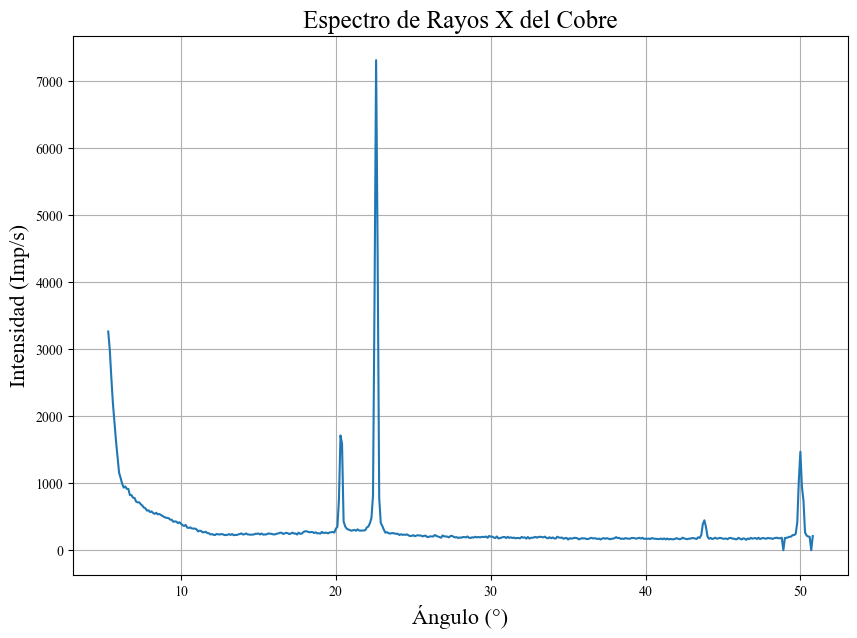

In [170]:
def lorentz(x, A, x0, gamma):
    return (A / np.pi) * (gamma / ((x - x0)**2 + gamma**2))

def double_lorentz(x, A1, x01, gamma1, A2, x02, gamma2):
    return lorentz(x, A1, x01, gamma1) + lorentz(x, A2, x02, gamma2)

def linear(x, a, b):
    return a*x + b

def voigt(x, A, x0, sigma, gamma):
    return A * voigt_profile(x - x0, sigma, gamma)

def double_voigt(x, A1, x01, sigma1, gamma1, A2, x02, sigma2, gamma2):
    return voigt(x, A1, x01, sigma1, gamma1) + voigt(x, A2, x02, sigma2, gamma2)

def bragg (d,theta,n):
    return 2/n* (d*np.sin(np.deg2rad(theta)))

def inc_bragg (d,theta,itheta,n):
    theta_=np.deg2rad(theta)
    itheta_=np.deg2rad(itheta)
    return 2/n* (d*np.cos(theta_)*itheta_)
def Error(valor_principal, incertidumbre):
    # Determinar cuántas cifras significativas tiene la incertidumbre
    if incertidumbre == 0:
        return valor_principal, incertidumbre  # Evita la división por cero
    
    cifras_significativas = -int(math.floor(math.log10(incertidumbre)))
    
    # Redondear el valor principal y la incertidumbre a esas cifras significativas
    valor_redondeado = round(valor_principal, cifras_significativas)
    incertidumbre_redondeada = round(incertidumbre, cifras_significativas)
    
    return valor_redondeado, incertidumbre_redondeada

data = pd.read_excel("rayos_x_dos_actividades.xlsx",sheet_name="Hoja1")
angulos=(data['Ángulo'].to_numpy())+2.3
intensidad=data['Intensidad'].to_numpy()

angulos

plt.rc('font', family='Times New Roman') 
plt.figure(figsize = (10, 7))
plt.plot(angulos,intensidad)
plt.ylabel("Intensidad (Imp/s)", fontsize=16)
plt.title("Espectro de Rayos X del Cobre", fontsize=18)
plt.xlabel("Ángulo (°)",fontsize=16)
plt.grid(True)


Esta es una gráfica ilustrativa. En realidad, debemos usar la ley de Bragg
\begin{equation*}
n \lambda = 2d \text{sin}\theta \quad,\quad n\in \mathbb{N}
\end{equation*}
 para pasar de ángulo a longitud de onda. En el código sumamos 2.3 grados a cada uno por que el valor teórico era 22.6° y a nosotros nos dió 20.3°, por eso el offset. Usamos la ley de Bragg con $n=1$ y $n=2$. Como nota, vemos como para ángulos pequeños la gráfica parece diverger. Esto es realmente porque en esta posición, el haz le da de lleno al cristal de LiF. Por lo tanto, estos ángulos no los vamos a tener en cuenta para los análisis que realicemos.

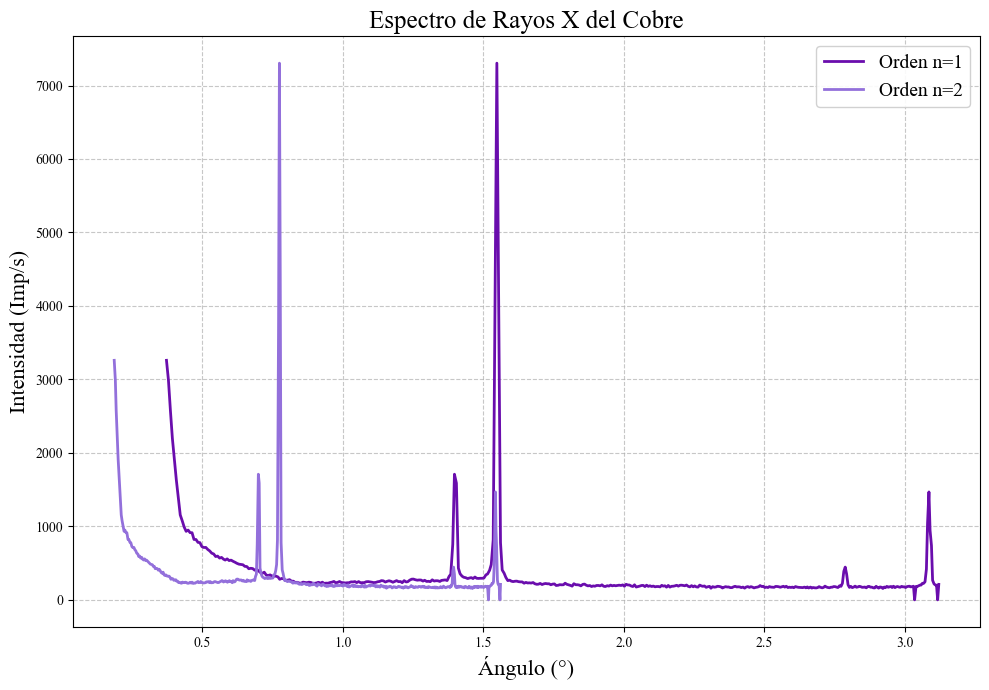

In [171]:
#Definimos antes las incertidumbres,como nuestro instrumento es analógico, su incertidumbre es su resolución.
inc_ang=0.1*np.ones(456)
inc_int=np.ones(456)
d=2.014 #Amstrongs
lambda1=bragg(d,angulos,1)
inc_lambda1=inc_bragg(d,angulos,inc_ang,1) 
lambda2=bragg(d,angulos,2)
inc_lambda2=inc_bragg(d,angulos,inc_ang,2) 
for i in range(len(lambda1)):
   lambda1[i]=Error(lambda1[i],inc_lambda1[i])[0]
   inc_lambda1[i]=Error(lambda1[i],inc_lambda1[i])[1]
for i in range(len(lambda2)):
   lambda2[i]=Error(lambda2[i],inc_lambda2[i])[0]
   inc_lambda2[i]=Error(lambda2[i],inc_lambda2[i])[1]


#Este pedacito de personalizar las gráficas lo hizo Deepseek. Yo no sabía como hacer que se viera así lindo, lo siento.

plt.rc('font', family='Times New Roman')
plt.figure(figsize=(10, 7))

# Curva 1: Azul oscuro (#1f77b4 es el azul estándar de matplotlib)
plt.plot(lambda1, intensidad, 
         color='#6A0DAD',  # Código HEX para azul oscuro
         linewidth=2, 
         label='Orden n=1')

# Curva 2: Azul claro (tono pastel)
plt.plot(lambda2, intensidad, 
         color='#9370DB',  # Código HEX para azul claro
         linewidth=2, 
         label='Orden n=2')

plt.ylabel("Intensidad (Imp/s)", fontsize=16)
plt.title("Espectro de Rayos X del Cobre", fontsize=18)
plt.xlabel("Ángulo (°)", fontsize=16)

# Leyenda con tamaño personalizado (14 puntos)
plt.legend(fontsize=14, 
           loc='best',  # Posición automática
           framealpha=0.9)  # Transparencia del fondo

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()  # Mejor ajuste de los elementos
plt.show()

Vemos como usar un segundo orden de difracción nos "corre" la gráfica para la izquierda. Ahora es momento de hallar las energías y longitudes de onda para las dos líneas características, es decir, $K_{\alpha}$ y $K_{\beta}$. Para esto, haremos dos ajustes, uno con una Loretziana y otro con el perfil de Voight.

C:\Users\PC\AppData\Local\Temp\ipykernel_7164\643685124.py:11: RuntimeWarning: overflow encountered in multiply
  return A * voigt_profile(x - x0, sigma, gamma)


Text(0.5, 1.0, 'Residuales')

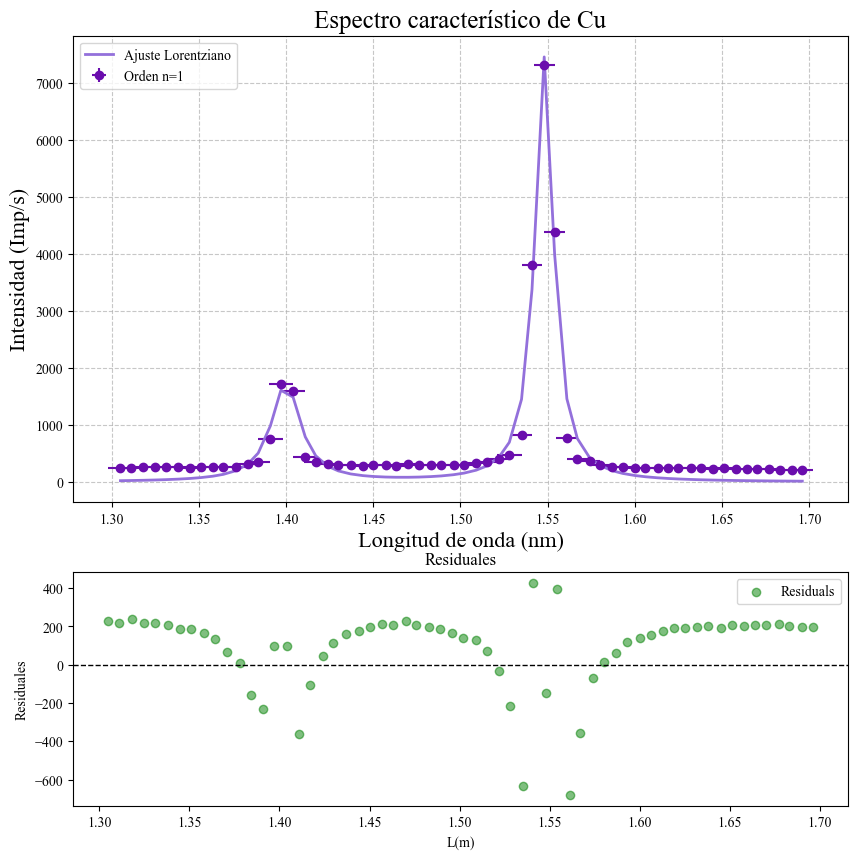

In [172]:
#Primero vamos a definir nuestras seeds para que esto converja como queremos
p0_lor=np.array([7304,1.54,0.02, 1750,1.39,0.02])
p0_voi=np.array([7304,1.54,0.01,0.02,1750,1.39,0.01,0.02]) 

#Ahora sí hacemos el fit y obtenemos nuestros parámetros con sus incertidumbres
param_lorentz,inc_lor=curve_fit(double_lorentz, lambda1, intensidad, p0=p0_lor, sigma=inc_int, absolute_sigma=True)
param_voight,inc_voight=curve_fit(double_voigt, lambda1, intensidad, p0=p0_voi,sigma=inc_int, absolute_sigma=True)

errors_lorentz = np.sqrt(np.diag(inc_lor))

A_1,x01, gamma1,A_2,x02, gamma2=param_lorentz
A1_err, x01_err, gamma1_err, A2_err, x02_err, gamma2_err = errors_lorentz

ajuste_lor1=double_lorentz(lambda1,A_1,x01,gamma1,A_2,x02,gamma2)
#Hacemos el cálculo de residuales

resid_lor1=(intensidad-ajuste_lor1)/inc_int

mask = (lambda1 >= 1.3) & (lambda1 <= 1.7)
lambda1_filtered = lambda1[mask]
intensidad_filtered = intensidad[mask]
ajuste_lor1_filtered = ajuste_lor1[mask]
inc_int_filtered=inc_int[mask]
inc_lambda1_filtered=inc_lambda1[mask]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1]})
ax1.errorbar(lambda1_filtered, intensidad_filtered, inc_int_filtered, inc_lambda1_filtered,color='#6A0DAD', fmt='o', label='Orden n=1')
ax1.plot(lambda1_filtered, ajuste_lor1_filtered, color='#9370DB', linewidth=2, label=f'Ajuste Lorentziano')
ax1.set_xlabel("Longitud de onda (nm)", fontsize=16)
ax1.set_ylabel("Intensidad (Imp/s)", fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')
ax1.set_title('Espectro característico de Cu', fontsize=18)

resid_lor1_filtered=resid_lor1[mask]
ax2.scatter(lambda1_filtered, resid_lor1_filtered, color='green', alpha=0.5, label='Residuals')
ax2.axhline(0, color='black', linewidth=1, linestyle='--')
ax2.set_xlabel('L(m)')
ax2.set_ylabel('Residuales')
ax2.legend(loc='upper right')
ax2.set_title('Residuales')



C:\Users\PC\AppData\Local\Temp\ipykernel_7164\643685124.py:11: RuntimeWarning: overflow encountered in multiply
  return A * voigt_profile(x - x0, sigma, gamma)


(1.399849, 5e-06)

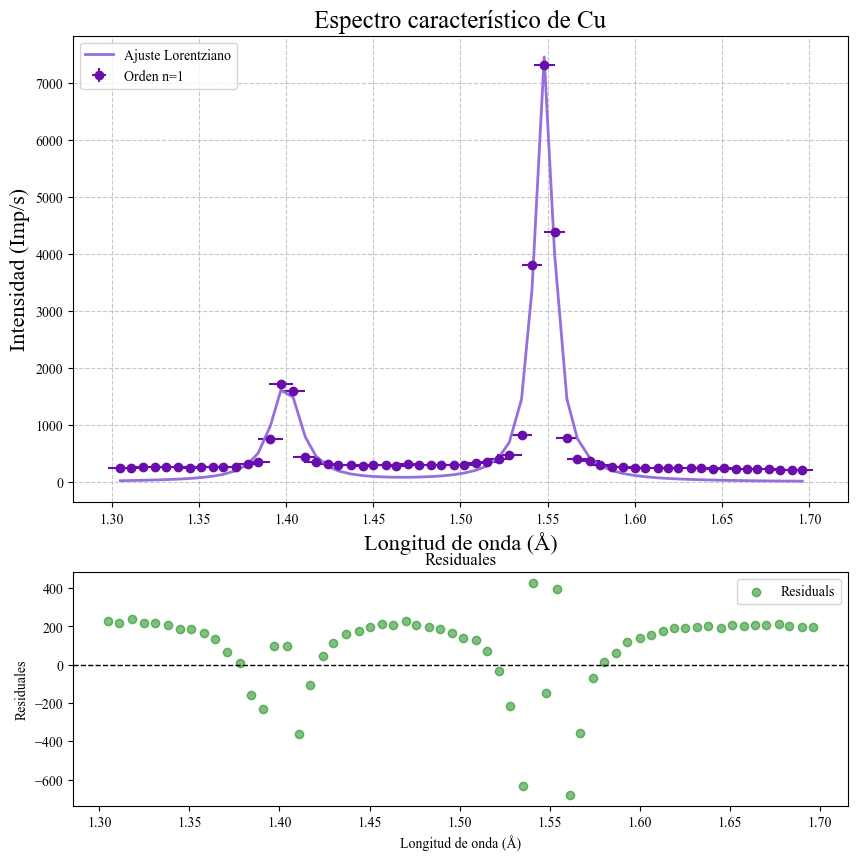

In [173]:
#Bueno,ahora es básicamente hacer lo mismo pero cambiar todos los números 1 por 2 xd.
#Primero vamos a definir nuestras seeds para que esto converja como queremos
p0_lor=np.array([7304,1.54,0.02, 1750,1.39,0.02])
p0_voi=np.array([7304,1.54,0.01,0.02,1750,1.39,0.01,0.02]) 

#Ahora sí hacemos el fit y obtenemos nuestros parámetros con sus incertidumbres
param_lorentz,inc_lor=curve_fit(double_lorentz, lambda1, intensidad, p0=p0_lor, sigma=inc_int, absolute_sigma=True)
param_voight,inc_voight=curve_fit(double_voigt, lambda1, intensidad, p0=p0_voi,sigma=inc_int, absolute_sigma=True)

errors_lorentz = np.sqrt(np.diag(inc_lor))

A_1,x01, gamma1,A_2,x02, gamma2=param_lorentz
A1_err, x01_err, gamma1_err, A2_err, x02_err, gamma2_err = errors_lorentz

ajuste_lor1=double_lorentz(lambda1,A_1,x01,gamma1,A_2,x02,gamma2)
#Hacemos el cálculo de residuales

resid_lor1=(intensidad-ajuste_lor1)/inc_int

mask = (lambda1 >= 1.3) & (lambda1 <= 1.7)
lambda1_filtered = lambda1[mask]
intensidad_filtered = intensidad[mask]
ajuste_lor1_filtered = ajuste_lor1[mask]
inc_int_filtered=inc_int[mask]
inc_lambda1_filtered=inc_lambda1[mask]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1]})
ax1.errorbar(lambda1_filtered, intensidad_filtered, inc_int_filtered, inc_lambda1_filtered,color='#6A0DAD', fmt='o', label='Orden n=1')
ax1.plot(lambda1_filtered, ajuste_lor1_filtered, color='#9370DB', linewidth=2, label=f'Ajuste Lorentziano')
ax1.set_xlabel("Longitud de onda (Å)", fontsize=16)
ax1.set_ylabel("Intensidad (Imp/s)", fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')
ax1.set_title('Espectro característico de Cu', fontsize=18)

resid_lor1_filtered=resid_lor1[mask]
ax2.scatter(lambda1_filtered, resid_lor1_filtered, color='green', alpha=0.5, label='Residuals')
ax2.axhline(0, color='black', linewidth=1, linestyle='--')
ax2.set_xlabel('Longitud de onda (Å)')
ax2.set_ylabel('Residuales')
ax2.legend(loc='upper right')
ax2.set_title('Residuales')

l_a1_lor=Error(x01,x01_err)
l_b1_lor=Error(x02,x02_err)
l_b1_lor


Podemos ver la "forma" esperada para los residuales pero solo en las lineas caracterísitcas. Los residuales realmente no son muy aleatorios, dando así a entender que el ajuste no es muy fiable. Además, los valores para las longitudes de onda respectivas encontrados son $K_{\alpha}=(1.548031 \pm 1 \times 10^{-6})Å $ y $K_{\beta}=(1.399849 \pm 5 \times 10^{-6})Å $.Ahora veamos que sucede con el perfil de Voight.


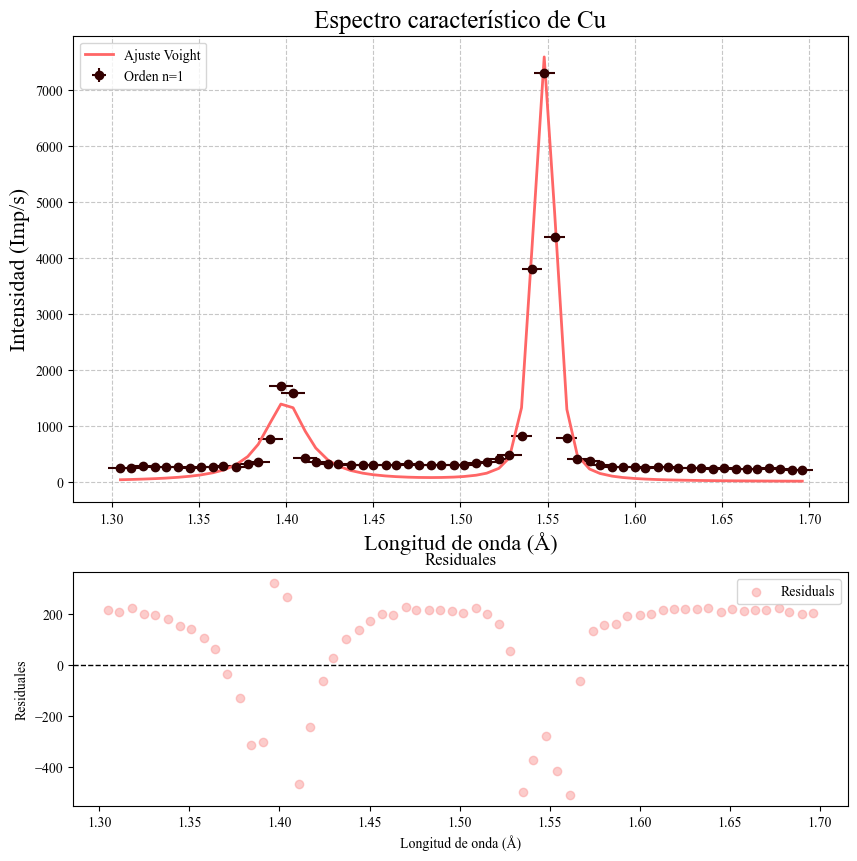

In [174]:
errors_voight = np.sqrt(np.diag(inc_voight))


A_1v,x01v, gamma1v, sigma1,A_2v,x02v, sigma2, gamma2v=param_voight
A1_errv, x01_errv,sigma1_err, gamma1_errv, A2_errv, x02_errv,sigma2_err, gamma2_errv = errors_voight

ajuste_voi1=double_voigt(lambda1,A_1v,x01v, sigma1,gamma1v,A_2v,x02v, sigma2,gamma2v)
#Hacemos el cálculo de residuales

resid_lor1=(intensidad-ajuste_voi1)/inc_int

mask = (lambda1 >= 1.3) & (lambda1 <= 1.7)
lambda1_filtered = lambda1[mask]
intensidad_filtered = intensidad[mask]
ajuste_voi1_filtered = ajuste_voi1[mask]
inc_int_filtered=inc_int[mask]
inc_lambda1_filtered=inc_lambda1[mask]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1]})
ax1.errorbar(lambda1_filtered, intensidad_filtered, inc_int_filtered, inc_lambda1_filtered,color='#330000', fmt='o', label='Orden n=1')
ax1.plot(lambda1_filtered, ajuste_voi1_filtered, color='#ff6666', linewidth=2, label=f'Ajuste Voight')
ax1.set_xlabel("Longitud de onda (Å)", fontsize=16)
ax1.set_ylabel("Intensidad (Imp/s)", fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')
ax1.set_title('Espectro característico de Cu', fontsize=18)

resid_lor1_filtered=resid_lor1[mask]
ax2.scatter(lambda1_filtered, resid_lor1_filtered, color='#fb9a99', alpha=0.5, label='Residuals')
ax2.axhline(0, color='black', linewidth=1, linestyle='--')
ax2.set_xlabel('Longitud de onda (Å)')
ax2.set_ylabel('Residuales')
ax2.legend(loc='upper right')
ax2.set_title('Residuales')

v_a1_=Error(x01v,x01_errv)
v_b1_=Error(x02v,x02_errv)


Ahora utilizamos un perfil de Voight, y en este caso, las longitudes asociadas son: $K_{\alpha}=(1.547952 \pm 1 \times10^{-6})Å $ y $K_{\beta}=(1.399708 \pm 8 \times 0^{-6})Å $. Recordemos que todo esto lo hicimos con un orden de difracción $n=1$. Ahora veamos qué sucede con $n=2$. 


((1.543004, 2e-06), (-0.1767, 0.0008))

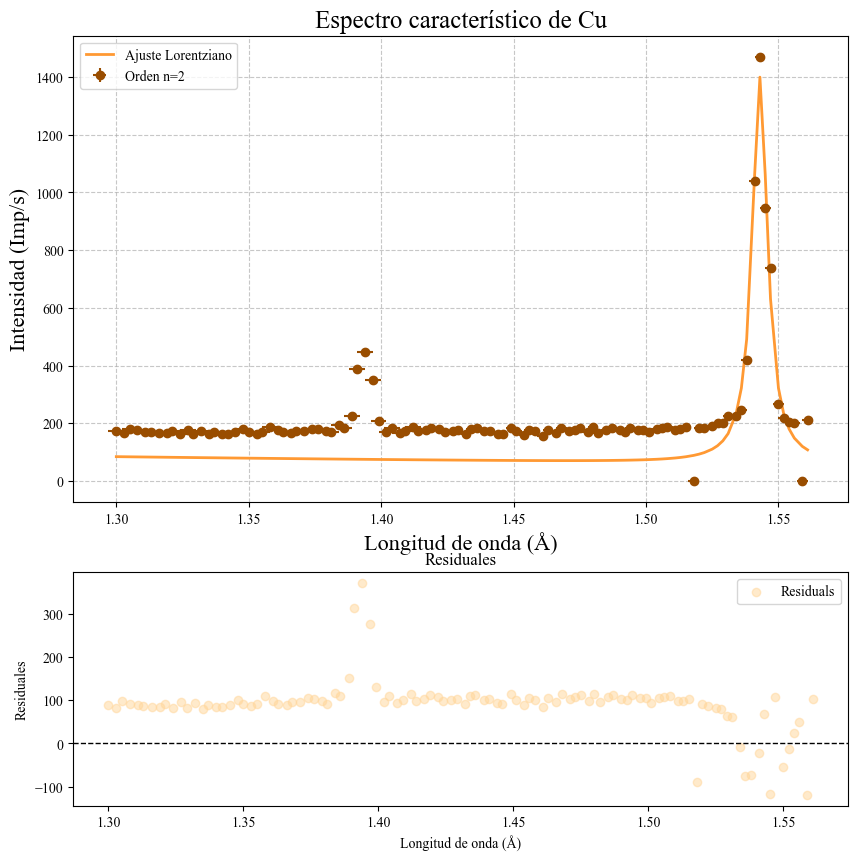

In [175]:
#Bueno,ahora es básicamente hacer lo mismo pero cambiar todos los números 1 por 2 xd.
#Primero vamos a definir nuestras seeds para que esto converja como queremos
p0_lor=np.array([7304,1.542,0.02, 1750,1.3,0.02])
p0_voi=np.array([7304,1.54,0.01,0.02,1750,1.39,0.01,0.02]) 

#Ahora sí hacemos el fit y obtenemos nuestros parámetros con sus incertidumbres
param_lorentz2,inc_lor2=curve_fit(double_lorentz, lambda2, intensidad, p0=p0_lor, sigma=inc_int, absolute_sigma=True)
param_voight2,inc_voight2=curve_fit(double_voigt, lambda2, intensidad, p0=p0_voi,sigma=inc_int, absolute_sigma=True)

errors_lorentz2 = np.sqrt(np.diag(inc_lor2))

A_12,x012, gamma12,A_22,x022, gamma22=param_lorentz2
A1_err2, x01_err2, gamma1_err2, A2_err2, x02_err2, gamma2_err2 = errors_lorentz2 

ajuste_lor2=double_lorentz(lambda2,A_12,x012,gamma12,A_22,x022,gamma22)
#Hacemos el cálculo de residuales

resid_lor2=(intensidad-ajuste_lor2)/inc_int

mask = (lambda2 >= 1.3) & (lambda2 <= 1.7)
lambda2_filtered = lambda2[mask]
intensidad_filtered = intensidad[mask]
ajuste_lor2_filtered = ajuste_lor2[mask]
inc_int_filtered=inc_int[mask]
inc_lambda2_filtered=inc_lambda2[mask]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1]})
ax1.errorbar(lambda2_filtered, intensidad_filtered, inc_int_filtered, inc_lambda2_filtered,color='#994d00', fmt='o', label='Orden n=2')
ax1.plot(lambda2_filtered, ajuste_lor2_filtered, color='#ff9933', linewidth=2, label=f'Ajuste Lorentziano')
ax1.set_xlabel("Longitud de onda (Å)", fontsize=16)
ax1.set_ylabel("Intensidad (Imp/s)", fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')
ax1.set_title('Espectro característico de Cu', fontsize=18)

resid_lor2_filtered=resid_lor2[mask]
ax2.scatter(lambda2_filtered, resid_lor2_filtered, color='#ffd699', alpha=0.5, label='Residuals')
ax2.axhline(0, color='black', linewidth=1, linestyle='--')
ax2.set_xlabel('Longitud de onda (Å)')
ax2.set_ylabel('Residuales')
ax2.legend(loc='upper right')
ax2.set_title('Residuales')

l_a2_lor=Error(x012,x01_err2)
l_b2_lor=Error(x022,x02_err2)
(l_a2_lor,l_b2_lor)


En este caso, vemos un patrón más bien errático en el ajuste con respecto a nuestros datos (aunque los residuales parecen ser correctos). A pesar de eso, logramos un buen estimado para la longitud de onda para $K_{\alpha}$, la cual nos da $(1.543004 \pm 2 \times 10^{-6}) Å$; sin embargo, no corrimos la misma suerte para $K_{\beta}$, esta se alejó muchísimo. La longitud de onda nos dio $(-0.1767 \pm 0.0008) Å$. Esto se puede deber a la pequeña cantidad de datos para esta línea, o a una mala elección de la semilla. Probemos con el perfil de Voight.

(1.54341, 1e-05)

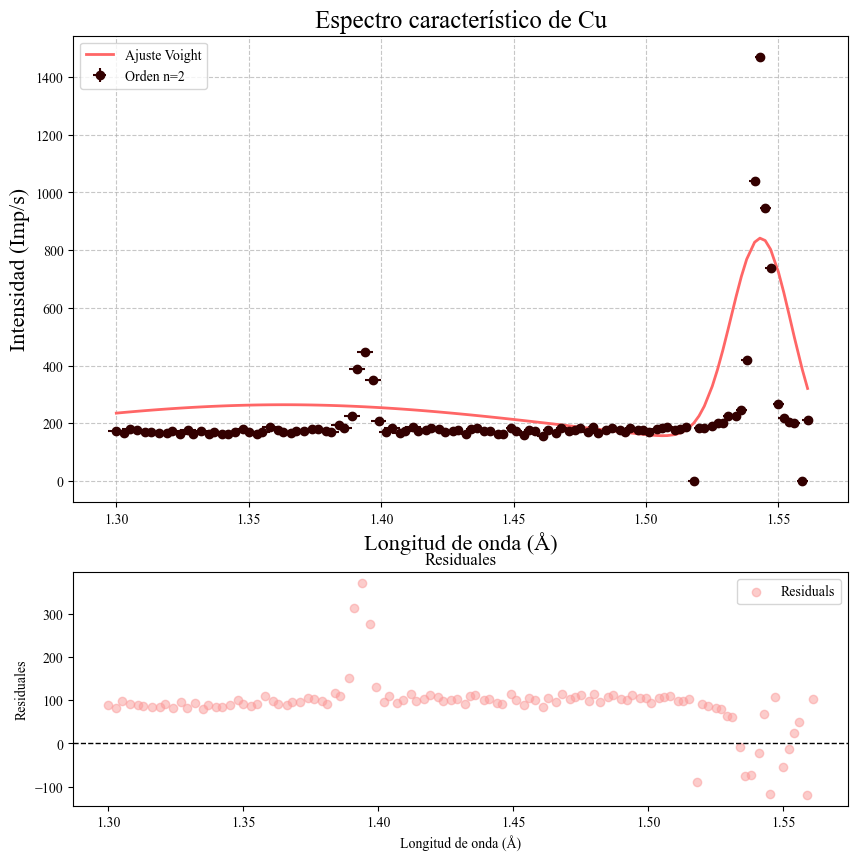

In [176]:
#De nuevo, solo debemos cambiar los 1 por 2.
errors_voight2 = np.sqrt(np.diag(inc_voight2))


A_1v2,x01v2, gamma1v2, sigma12,A_2v2,x02v2, sigma22, gamma2v2=param_voight2
A1_errv2, x01_errv2,sigma1_err2, gamma1_errv2, A2_errv2, x02_errv2,sigma2_err2, gamma2_errv2 = errors_voight2

ajuste_voi2=double_voigt(lambda2,A_1v2,x01v2, sigma12,gamma1v2,A_2v2,x02v2, sigma22,gamma2v2)
#Hacemos el cálculo de residuales

resid_lor2=(intensidad-ajuste_voi2)/inc_int

mask = (lambda2 >= 1.3) & (lambda2 <= 1.7)
lambda2_filtered = lambda2[mask]
intensidad_filtered = intensidad[mask]
ajuste_voi2_filtered = ajuste_voi2[mask]
inc_int_filtered=inc_int[mask]
inc_lambda2_filtered=inc_lambda2[mask]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1]})
ax1.errorbar(lambda2_filtered, intensidad_filtered, inc_int_filtered, inc_lambda2_filtered,color='#330000', fmt='o', label='Orden n=2')
ax1.plot(lambda2_filtered, ajuste_voi2_filtered, color='#ff6666', linewidth=2, label=f'Ajuste Voight')
ax1.set_xlabel("Longitud de onda (Å)", fontsize=16)
ax1.set_ylabel("Intensidad (Imp/s)", fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')
ax1.set_title('Espectro característico de Cu', fontsize=18)

resid_lor1_filtered=resid_lor1[mask]
ax2.scatter(lambda2_filtered, resid_lor2_filtered, color='#fb9a99', alpha=0.5, label='Residuals')
ax2.axhline(0, color='black', linewidth=1, linestyle='--')
ax2.set_xlabel('Longitud de onda (Å)')
ax2.set_ylabel('Residuales')
ax2.legend(loc='upper right')
ax2.set_title('Residuales')

v_a12=Error(x01v2,x01_errv2)
v_b12=Error(x02v2,x02_errv2)

v_a12

Bueno, como podemos ver a simple vista, el perfil no se ajusta en casi nada a los datos. Presumiblemente por las mismas razones por las cuales falló el ajuste Lorentziano. Algo que podría ayudar sería limitar el rango en el cual hacemos el ajuste, es decir, acotar nuestra variable *lambda2*. De todas formas, el valor obtenido para la longitud de onda relacionada con $K_{\alpha}$ nos da $(1.54341 \pm  1 \times 10^{-5})Å$, lo cual va bastante acorde a lo esperado.

En la literatura que usamos los valores para estas longitudes son $1.54 Å$ y $1.39221 Å$ respectivamente. Podemos ver que en todos los casos, menos para $K_{\beta}$ con $n=2$, tenemos exactitud. En términos de precisión, nuestros ajustes son precisos en todos los casos.

**Actividad 3**



Vamos a estudiar la dependencia de la intensidad, para las líneas $K_{\beta}$ y $K_{\alpha}$ del cobre, con el voltaje y la corriente. Si tenemos una longitud de onda dada, debe seguir la siguiente relación

\begin{equation*}
I_{\lambda}=I_0b(U_a-U_K)^{3/2}.
\end{equation*}

Siendo $I_0$ la corriente, $U_a$ el voltaje en el ánodo y $U_K$ el potencial de ionización del orbital K. Vamos a tomarlo como $U_k= 9,979 \text{keV}$. Primero vamos a graficar $I \text{ vs } \lambda$ para diferentes voltajes con un ajuste Lorentziano.

In [177]:
data=pd.read_excel("rayos_x_dos_actividades.xlsx",sheet_name="Hoja3")
data1=pd.read_excel("rayos_x_dos_actividades.xlsx",sheet_name="Hoja4")
angulos_v=(data['Ángulo 1'].to_numpy())+2.1
angulos_i=(data1['Ángulo 2'].to_numpy())+2.1
indices_voltajes=["11kV", "14kV", "17kV", "20kV", "23kV", "26kV", "29kV",  "32kV","35kV"]
voltajes=np.array([11,14,17,20,23,26,29,32,35])
indices_corrientes=["0.1mA","0.2mA","0.3mA","0.4mA","0.5mA","0.6mA","0.7mA","0.8mA","0.8mA","1mA"]
corrientes=np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
inc_ang_v=0.1*np.ones(81)
inc_int_v=np.ones(81)
inc_ang_i=0.1*np.ones(41)
inc_int_i=np.ones(41)


intensidades_v=[]
intensidades_i=[]
for i in range(0,len(indices_voltajes)):
    intensidades_v.append(data[indices_voltajes[i]].to_numpy())

for i in range(0,len(indices_corrientes)):
    intensidades_i.append(data1[indices_corrientes[i]].to_numpy())

lambda_v=bragg(d, angulos_v,1)
lambda_i=bragg(d, angulos_i,1)
inc_lambda_v=inc_bragg(d,angulos_v,inc_ang_v,1)
inc_lambda_i=inc_bragg(d,angulos_i,inc_ang_i,1)

print(type(lambda_v),type(inc_ang_v))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Ahora definamos las funciones nuevas que suaremos en esta actividad.

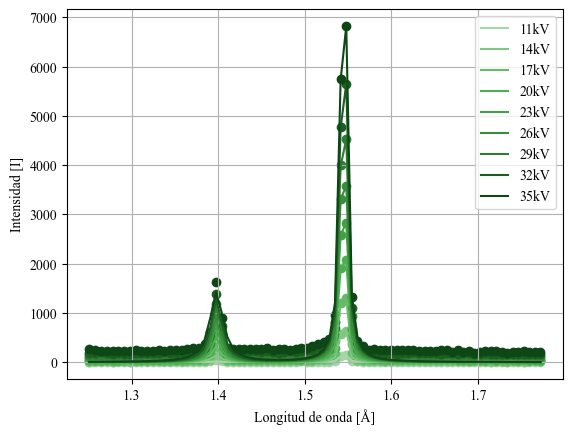

In [178]:
p0_lor=np.array([7304,1.54,0.02, 1750,1.39,0.02])
Uk = 9.979 # keV 
Ua = 35 # keV
I0 = 1 # 1mA

colores = [
    "#A5D6A7",  # Verde suave
    "#81C784",  # Verde fresco
    "#66BB6A",  # Verde estándar
    "#4CAF50",  # Verde vibrante
    "#43A047",  # Verde equilibrado
    "#388E3C",  # Verde fuerte
    "#2E7D32",  # Verde intenso
    "#1B5E20",  # Verde oscuro
    "#0D4716"   # Verde muy oscuro
]
def KVoltaje (U,b):
    return b*I0*(U - Uk)**(3/2)

def KCorriente (I,b):
    return b*I*(Ua - Uk)**(3/2)



def ajustar_lor (I,lambdas,seed):
    param_lorentz,inc_lor=curve_fit(double_lorentz, lambdas, I, p0=seed, sigma=inc_int_v, absolute_sigma=True)
    errors_lorentz = np.sqrt(np.diag(inc_lor))

    A_1,x01, gamma1,A_2,x02, gamma2=param_lorentz
    A1_err, x01_err, gamma1_err, A2_err, x02_err, gamma2_err = errors_lorentz

    IKb=double_lorentz(x02,*param_lorentz)
    IKa=double_lorentz(x01,*param_lorentz)

    ajuste_lor=double_lorentz(lambdas,A_1,x01,gamma1,A_2,x02,gamma2)
    return (ajuste_lor,IKb,IKa)

for i in range(len(intensidades_v)):
    y=ajustar_lor(intensidades_v[i],lambda_v,p0_lor)[0]
    plt.scatter(lambda_v,intensidades_v[i],color=colores[i])
    plt.plot(lambda_v, y, color = colores[i], label = indices_voltajes[i])
plt.xlabel("Longitud de onda [Å]")
plt.ylabel("Intensidad [I]")
plt.grid()
plt.legend()


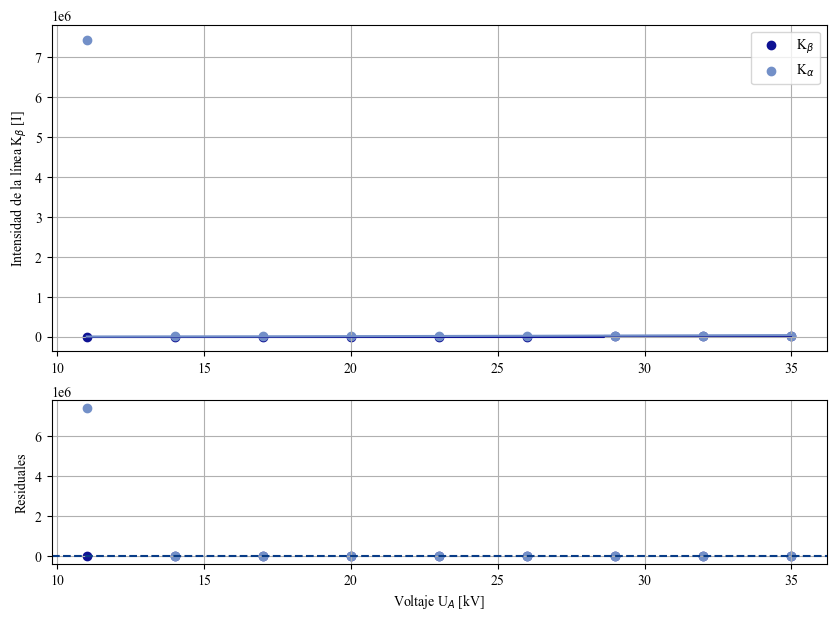

In [179]:
Kb=[]
Ka=[]
for i in range(len(intensidades_v)):
    Kb.append(ajustar_lor(intensidades_v[i],lambda_v,p0_lor)[1])
    Ka.append(ajustar_lor(intensidades_v[i],lambda_v,p0_lor)[2])
Kb=np.array(Kb)
Ka=np.array(Ka)

y_kb,unc_kb=curve_fit(KVoltaje,voltajes, Kb)
y_ka, unc_ka=curve_fit(KVoltaje,voltajes, Ka)
inc_kb=np.sqrt(np.diag(unc_kb))
inc_ka=np.sqrt(np.diag(unc_ka))

res_ka=Ka-KVoltaje(voltajes,*y_ka)
res_kb=Kb-KVoltaje(voltajes,*y_kb)

voltajes_ = np.linspace(min(voltajes), max(voltajes), 1000)   

y_kb[0],inc_kb[0]=Error(y_kb[0],inc_kb[0])
y_kb[0],inc_kb[0]

figure, axis = plt.subplots(2, 1, figsize = (10, 7), gridspec_kw={'height_ratios': [2, 1]})

axis[0].scatter(voltajes, Kb, color = '#0e1293', label = r"K$_\beta$")
axis[0].scatter(voltajes, Ka, color = '#7390c8', label = r"K$_\alpha$")
axis[0].plot(voltajes_, KVoltaje(voltajes_, *y_kb), color = '#0e1293')
axis[0].plot(voltajes_, KVoltaje(voltajes_, *y_ka), color = '#7390c8')
axis[0].set_ylabel(r"Intensidad de la línea K$_\beta$ [I]")

axis[1].scatter(voltajes, res_kb, color = "#0e1293")
axis[1].scatter(voltajes, res_ka, color = "#7390c8")
axis[1].axhline(y = 0, color = "#083c87", linestyle = "--")
axis[1].set_ylabel(r"Residuales")
axis[1].set_xlabel(r"Voltaje U$_A$ [kV]")
axis[0].grid()
axis[0].legend()
axis[1].grid()

plt.savefig("Cambio UA.pdf")

Esto está claramente mal. Toca corregir para el informe.
